# House Prices Competition

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV


from utils import (
    MappingEncoder,
    NeighborhoodMapper,
    get_categorical_columns,
    get_num_missing_values,
    get_unique_values_column,
    create_heatmap,
)

## Preprocessing

In [2]:
# Read the data
data = pd.read_csv("../input/train.csv", index_col="Id")
X_test = pd.read_csv("../input/test.csv", index_col="Id")

print(data.shape)
data.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Remove rows with missing target, separate target from predictors
data.dropna(axis=0, subset=["SalePrice"], inplace=True)
X = data.copy()
y = X["SalePrice"]
X.drop(["SalePrice"], axis=1, inplace=True)

### Explore the data

Get number of missing values per column

In [4]:
missing_val_df = get_num_missing_values(X, treshold=0.3)

Missing values in variable columns:
       attribute  num_missing %_missing
0         PoolQC         1453    99.52%
1    MiscFeature         1406     96.3%
2          Alley         1369    93.77%
3          Fence         1179    80.75%
4     MasVnrType          872    59.73%
5    FireplaceQu          690    47.26%
6    LotFrontage          259    17.74%
7     GarageType           81     5.55%
8    GarageYrBlt           81     5.55%
9   GarageFinish           81     5.55%
10    GarageQual           81     5.55%
11    GarageCond           81     5.55%
12  BsmtFinType2           38      2.6%
13  BsmtExposure           38      2.6%
14  BsmtFinType1           37     2.53%
15      BsmtCond           37     2.53%
16      BsmtQual           37     2.53%
17    MasVnrArea            8     0.55%
18    Electrical            1     0.07%


Get categorical columns

In [5]:
categorical_df = get_categorical_columns(X)
categorical_cols = categorical_df["attribute"].to_list()

Columns with categorical data:
        attribute  n_unique
0    Neighborhood        25
1     Exterior2nd        16
2     Exterior1st        15
3        SaleType         9
4      Condition1         9
5      Condition2         8
6      HouseStyle         8
7        RoofMatl         8
8      Functional         7
9    BsmtFinType2         6
10        Heating         6
11      RoofStyle         6
12  SaleCondition         6
13   BsmtFinType1         6
14     GarageType         6
15     Foundation         6
16     Electrical         5
17    FireplaceQu         5
18      HeatingQC         5
19     GarageQual         5
20     GarageCond         5
21       MSZoning         5
22      LotConfig         5
23      ExterCond         5
24       BldgType         5
25   BsmtExposure         4
26    MiscFeature         4
27          Fence         4
28       LotShape         4
29    LandContour         4
30       BsmtCond         4
31    KitchenQual         4
32      ExterQual         4
33       BsmtQual

Get categorical columns with missing values

In [6]:
# Join the above dataframes to get the categorical with missing values
missing_cat_df = pd.merge(missing_val_df, categorical_df, on="attribute", how="inner")
print(missing_cat_df)

       attribute  num_missing %_missing  n_unique
0         PoolQC         1453    99.52%         3
1    MiscFeature         1406     96.3%         4
2          Alley         1369    93.77%         2
3          Fence         1179    80.75%         4
4     MasVnrType          872    59.73%         3
5    FireplaceQu          690    47.26%         5
6     GarageType           81     5.55%         6
7   GarageFinish           81     5.55%         3
8     GarageQual           81     5.55%         5
9     GarageCond           81     5.55%         5
10  BsmtFinType2           38      2.6%         6
11  BsmtExposure           38      2.6%         4
12  BsmtFinType1           37     2.53%         6
13      BsmtCond           37     2.53%         4
14      BsmtQual           37     2.53%         4
15    Electrical            1     0.07%         5


Get the rest of categorical values


In [7]:
# Subtract dataframes to get the rest of categorical values
rest_cat_df = categorical_df[~categorical_df["attribute"].isin(missing_val_df["attribute"].to_list())]
print(rest_cat_df)

        attribute  n_unique
0    Neighborhood        25
1     Exterior2nd        16
2     Exterior1st        15
3        SaleType         9
4      Condition1         9
5      Condition2         8
6      HouseStyle         8
7        RoofMatl         8
8      Functional         7
10        Heating         6
11      RoofStyle         6
12  SaleCondition         6
15     Foundation         6
18      HeatingQC         5
21       MSZoning         5
22      LotConfig         5
23      ExterCond         5
24       BldgType         5
28       LotShape         4
29    LandContour         4
31    KitchenQual         4
32      ExterQual         4
34      LandSlope         3
37     PavedDrive         3
39      Utilities         2
40     CentralAir         2
41         Street         2


Get numerical columns with missing values

In [8]:
numerical_cols = [
    item
    for item in X.columns.to_list()
    if item not in categorical_df["attribute"].to_list()
]
missing_numerical_cols = list(
    set(numerical_cols) & set(missing_val_df["attribute"].to_list())
)
print(missing_val_df[missing_val_df["attribute"].isin(missing_numerical_cols)])

      attribute  num_missing %_missing
6   LotFrontage          259    17.74%
8   GarageYrBlt           81     5.55%
17   MasVnrArea            8     0.55%


### First - let's handle missing values for cetegorical columns

Custom encoder for ordinal categorical data:

- PoolQC,
- FireplaceQu,
- GarageFinish,
- GarageQual,
- GarageCond,
- BsmtExposure,
- BsmtQual,
- BsmtCond,
- ExterCond,
- ExterQual,
- HeatingQC,
- KitchenQual,
- CentralAir


In [9]:
get_unique_values_column(X, "PoolQC")  # handle_unknown="median"
poolqc_dict = {"Na": 0, "Fa": 1, "Gd": 2, "Ex": 3}

get_unique_values_column(X, "FireplaceQu")  # handle_unknown="median"
fireplacequ_dict = {"Na": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

get_unique_values_column(X, "GarageFinish")  # handle_unknown="median"
garagefinish_dict = {"Na": 0, "Unf": 1, "RFn": 2, "Fin": 3}

get_unique_values_column(X, "GarageQual")  # handle_unknown="median"
garagequal_dict = {"Na": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

get_unique_values_column(X, "GarageCond")  # handle_unknown="median"
garagecond_dict = {"Na": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

get_unique_values_column(X, "BsmtExposure")  # handle_unknown="median"
bsmtexposure_dict = {"Na": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}

get_unique_values_column(X, "BsmtQual")  # handle_unknown="median"
bsmtqual_dict = {"Na": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

get_unique_values_column(X, "BsmtCond")  # handle_unknown="median"
bsmtcond_dict = {"Na": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

get_unique_values_column(X, "ExterCond")  # handle_unknown="zero"
extercond_dict = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

get_unique_values_column(X, "ExterQual")  # handle_unknown="zero"
exterqual_dict = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

get_unique_values_column(X, "HeatingQC")  # handle_unknown="zero"
heatingqc_dict = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

get_unique_values_column(X, "KitchenQual")  # handle_unknown="zero"
kitchenqual_dict = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

get_unique_values_column(X, "CentralAir")  # handle_unknown="zero"
centralair_dict = {"N": 0, "Y": 1}

columns_to_mapencode_dict = {
    "PoolQC": poolqc_dict,
    "FireplaceQu": fireplacequ_dict,
    "GarageFinish": garagefinish_dict,
    "GarageQual": garagequal_dict,
    "GarageCond": garagecond_dict,
    "BsmtExposure": bsmtexposure_dict,
    "BsmtQual": bsmtqual_dict,
    "BsmtCond": bsmtcond_dict,
    "ExterCond": extercond_dict,
    "ExterQual": exterqual_dict,
    "HeatingQC": heatingqc_dict,
    "KitchenQual": kitchenqual_dict,
    "CentralAir": centralair_dict,
}

PoolQC	[nan, 'Ex', 'Fa', 'Gd']
FireplaceQu	[nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po']
GarageFinish	['RFn', 'Unf', 'Fin', nan]
GarageQual	['TA', 'Fa', 'Gd', nan, 'Ex', 'Po']
GarageCond	['TA', 'Fa', nan, 'Gd', 'Po', 'Ex']
BsmtExposure	['No', 'Gd', 'Mn', 'Av', nan]
BsmtQual	['Gd', 'TA', 'Ex', nan, 'Fa']
BsmtCond	['TA', 'Gd', nan, 'Fa', 'Po']
ExterCond	['TA', 'Gd', 'Fa', 'Po', 'Ex']
ExterQual	['Gd', 'TA', 'Ex', 'Fa']
HeatingQC	['Ex', 'Gd', 'TA', 'Fa', 'Po']
KitchenQual	['Gd', 'TA', 'Ex', 'Fa']
CentralAir	['Y', 'N']


One hot encode, using OneHotEncoder(sparse_output=False, handle_unknown="ignore"):

- MiscFeature,
- Alley,
- Fence,
- MasVnrType,
- GarageType,
- BsmtFinType1,
- BsmtFinType2,
- Electrical,
- Exterior1st,
- Exterior2nd,
- Condition1,
- Condition2,
- SaleType,
- HouseStyle,
- RoofMatl,
- Functional,
- RoofStyle,
- SaleCondition,
- Heating,
- Foundation,
- LotConfig,
- MSZoning,
- BldgType,
- LandContour,
- LotShape,
- LandSlope,
- PavedDrive,
- Utilities,
- Street


In [10]:
get_unique_values_column(X, "MiscFeature")
get_unique_values_column(X, "Alley")
get_unique_values_column(X, "Fence")
get_unique_values_column(X, "MasVnrType")
get_unique_values_column(X, "GarageType")
get_unique_values_column(X, "BsmtFinType1")
get_unique_values_column(X, "BsmtFinType2")
get_unique_values_column(X, "Electrical")
get_unique_values_column(X, "Exterior1st")
get_unique_values_column(X, "Exterior2nd")
get_unique_values_column(X, "Condition1")
get_unique_values_column(X, "Condition2")
get_unique_values_column(X, "SaleType")
get_unique_values_column(X, "HouseStyle")
get_unique_values_column(X, "RoofMatl")
get_unique_values_column(X, "Functional")
get_unique_values_column(X, "RoofStyle")
get_unique_values_column(X, "SaleCondition")
get_unique_values_column(X, "Heating")
get_unique_values_column(X, "Foundation")
get_unique_values_column(X, "LotConfig")
get_unique_values_column(X, "MSZoning")
get_unique_values_column(X, "BldgType")
get_unique_values_column(X, "LandContour")
get_unique_values_column(X, "LotShape")
get_unique_values_column(X, "LandSlope")
get_unique_values_column(X, "PavedDrive")
get_unique_values_column(X, "Utilities")
get_unique_values_column(X, "Street")

columns_to_onehotencode = [
    "MiscFeature",
    "Alley",
    "Fence",
    "MasVnrType",
    "GarageType",
    "BsmtFinType1",
    "BsmtFinType2",
    "Electrical",
    "Exterior1st",
    "Exterior2nd",
    "Condition1",
    "Condition2",
    "SaleType",
    "HouseStyle",
    "RoofMatl",
    "Functional",
    "RoofStyle",
    "SaleCondition",
    "Heating",
    "Foundation",
    "LotConfig",
    "MSZoning",
    "BldgType",
    "LandContour",
    "LotShape",
    "LandSlope",
    "PavedDrive",
    "Utilities",
    "Street",
]

MiscFeature	[nan, 'Shed', 'Gar2', 'Othr', 'TenC']
Alley	[nan, 'Grvl', 'Pave']
Fence	[nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw']
MasVnrType	['BrkFace', nan, 'Stone', 'BrkCmn']
GarageType	['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types']
BsmtFinType1	['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ']
BsmtFinType2	['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ']
Electrical	['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan]
Exterior1st	['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing', 'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn', 'Stone', 'ImStucc', 'CBlock']
Exterior2nd	['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng', 'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc', 'AsphShn', 'Stone', 'Other', 'CBlock']
Condition1	['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe']
Condition2	['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe']
SaleType	['WD', 'New', 'COD', 'ConLD', 'ConL

Regarding numerical columns, they will be simple imputed, because there are not a lot of missing values there

#### The last not modified column, Neighborhood will be transformed using KNN model, to merge some neighborhoods together

In [11]:
# Copy the data to a separate df beacause now Neighbourhood will be treated as a class
neighborhood_df = data.copy()
columns = [col for col in neighborhood_df.columns if col != "Neighborhood"] + [
    "Neighborhood"
]
neighborhood_df = neighborhood_df[columns]

In [12]:
neighborhood_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Neighborhood
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,CollgCr
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,Veenker
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,CollgCr
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,Crawfor
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,NoRidge


In [13]:
# Preprocessing numerical data
numerical_pipeline = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# Whole preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        (
            "poolqc_mapper",
            MappingEncoder(
                mapping_dict=poolqc_dict, column="PoolQC", handle_unknown="median"
            ),
            ["PoolQC"],
        ),
        (
            "fireplacequ_mapper",
            MappingEncoder(
                mapping_dict=fireplacequ_dict,
                column="FireplaceQu",
                handle_unknown="median",
            ),
            ["FireplaceQu"],
        ),
        (
            "garagefinish_mapper",
            MappingEncoder(
                mapping_dict=garagefinish_dict,
                column="GarageFinish",
                handle_unknown="median",
            ),
            ["GarageFinish"],
        ),
        (
            "garagequal_mapper",
            MappingEncoder(
                mapping_dict=garagequal_dict,
                column="GarageQual",
                handle_unknown="median",
            ),
            ["GarageQual"],
        ),
        (
            "garagecond_mapper",
            MappingEncoder(
                mapping_dict=garagecond_dict,
                column="GarageCond",
                handle_unknown="median",
            ),
            ["GarageCond"],
        ),
        (
            "bsmtexposure_mapper",
            MappingEncoder(
                mapping_dict=bsmtexposure_dict,
                column="BsmtExposure",
                handle_unknown="median",
            ),
            ["BsmtExposure"],
        ),
        (
            "bsmtqual_mapper",
            MappingEncoder(
                mapping_dict=bsmtqual_dict, column="BsmtQual", handle_unknown="median"
            ),
            ["BsmtQual"],
        ),
        (
            "bsmtcond_mapper",
            MappingEncoder(
                mapping_dict=bsmtcond_dict, column="BsmtCond", handle_unknown="median"
            ),
            ["BsmtCond"],
        ),
        (
            "extercond_mapper",
            MappingEncoder(
                mapping_dict=extercond_dict, column="ExterCond", handle_unknown="median"
            ),
            ["ExterCond"],
        ),
        (
            "exterqual_mapper",
            MappingEncoder(
                mapping_dict=exterqual_dict, column="ExterQual", handle_unknown="median"
            ),
            ["ExterQual"],
        ),
        (
            "heatingqc_mapper",
            MappingEncoder(
                mapping_dict=heatingqc_dict, column="HeatingQC", handle_unknown="median"
            ),
            ["HeatingQC"],
        ),
        (
            "kitchenqual_mapper",
            MappingEncoder(
                mapping_dict=kitchenqual_dict,
                column="KitchenQual",
                handle_unknown="median",
            ),
            ["KitchenQual"],
        ),
        (
            "centralair_mapper",
            MappingEncoder(
                mapping_dict=centralair_dict,
                column="CentralAir",
                handle_unknown="median",
            ),
            ["CentralAir"],
        ),
        (
            "one_hot_encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            columns_to_onehotencode,
        ),
        ("numerical_pipeline", numerical_pipeline, numerical_cols + ["SalePrice"]),
    ],
    remainder="passthrough",
)

In [14]:
neighborhood_df = preprocessor.fit_transform(neighborhood_df)
neighborhood_df = pd.DataFrame(neighborhood_df)
neighborhood_df.rename(columns={231: "neighborhood"}, inplace=True)

neighborhood_df.head()

,0,1,2,3,4,5,6,7,8,9,...,222,223,224,225,226,227,228,229,230,neighborhood
0,-0.064907,-1.008334,0.318475,0.262542,0.265618,-0.590555,0.583168,0.117884,-0.238112,1.052302,...,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273,CollgCr
1,-0.064907,0.64889,0.318475,0.262542,0.265618,2.220999,0.583168,0.117884,-0.238112,-0.689604,...,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.48911,-0.614439,0.007288,Veenker
2,-0.064907,0.64889,0.318475,0.262542,0.265618,0.34663,0.583168,0.117884,-0.238112,1.052302,...,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154,CollgCr
3,-0.064907,1.201298,-0.801942,0.262542,0.265618,-0.590555,-0.558153,1.929579,-0.238112,-0.689604,...,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281,Crawfor
4,-0.064907,0.64889,0.318475,0.262542,0.265618,1.283814,0.583168,0.117884,-0.238112,1.052302,...,0.56376,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.869843,NoRidge


Reduce the dimensionality

In [15]:
neighborhood_features = neighborhood_df.drop(columns=["neighborhood"])
neighborhood_target = neighborhood_df["neighborhood"]

tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(neighborhood_features)

In [16]:
neighborhood_target.head()

0    CollgCr
1    Veenker
2    CollgCr
3    Crawfor
4    NoRidge
Name: neighborhood, dtype: object

In [17]:
# Create a DataFrame to hold the data
features_2d_df = pd.DataFrame(features_2d, columns=["x", "y"])
features_2d_df["neighborhood"] = neighborhood_target

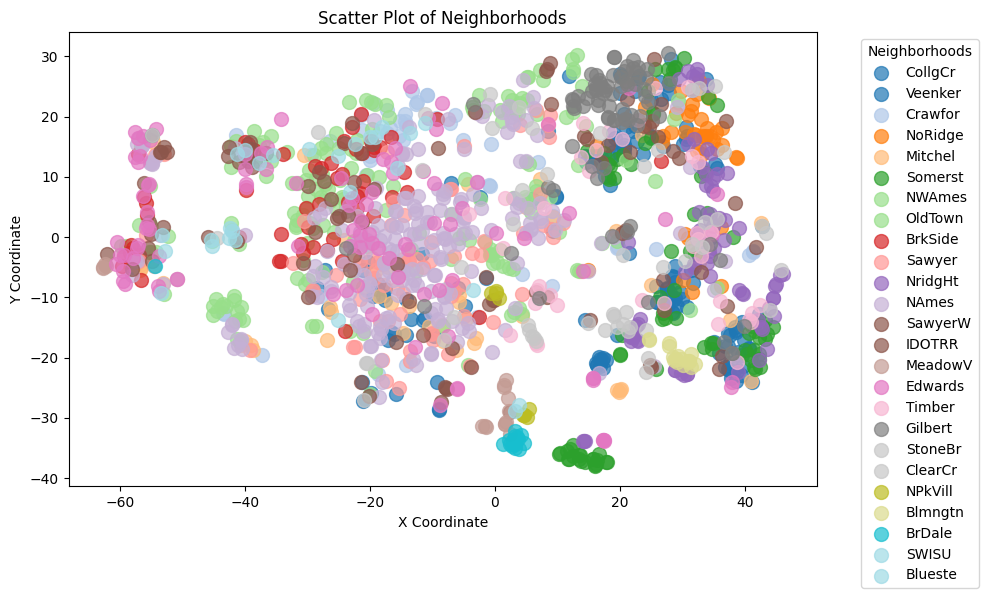

In [18]:
# Assign unique colors to each neighborhood
unique_neighborhoods = features_2d_df["neighborhood"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_neighborhoods)))
color_mapping = {
    neighborhood: colors[i] for i, neighborhood in enumerate(unique_neighborhoods)
}

# Create scatter plot
plt.figure(figsize=(10, 6))

for neighborhood in unique_neighborhoods:
    subset = features_2d_df[features_2d_df["neighborhood"] == neighborhood]
    plt.scatter(
        subset["x"],
        subset["y"],
        color=color_mapping[neighborhood],
        label=neighborhood,
        s=100,
        alpha=0.7,
    )

# Add legend
plt.legend(title="Neighborhoods", bbox_to_anchor=(1.05, 1), loc="upper left")

# Add labels and title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Scatter Plot of Neighborhoods")

# Show plot
plt.tight_layout()
plt.show()

So the plot tells me nothing, I'll simply focus on KMeans

Clustering

In [19]:
# Choosing 10 clusters as target number
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(features_2d)

neighborhood_clusters = pd.Series(clusters, name="cluster")
neighborhood_target_clusters = pd.concat(
    [neighborhood_target, neighborhood_clusters], axis=1
)

neighborhood_target_clusters.head()

,neighborhood,cluster
0,CollgCr,1
1,Veenker,5
2,CollgCr,1
3,Crawfor,0
4,NoRidge,1


Building a heatmap of the data to see to which cluster should each of the neighborhood go

In [20]:
heatmap_df = create_heatmap(neighborhood_target_clusters)

c:\Users\kkleist\OneDrive - DXC Production\Desktop\github\House-Prices-Competition\03-house-competition-model-stacking\utils\preprocessing.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  heatmap_df.loc[row[0], row[1]] += 1


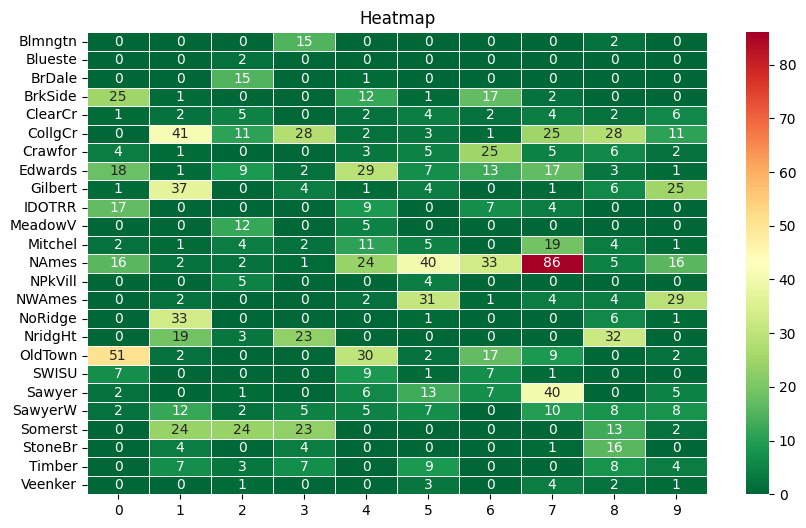

In [21]:
# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, cmap="RdYlGn_r", linewidths=0.5)
plt.title("Heatmap")
plt.show()

Get the max column value for each neighborhood

In [22]:
neighborhood_dict = {}

for index, row in heatmap_df.iterrows():
    print(f"{row.name}\t\tmax: {max(row)}\t\tcluster: {row.idxmax()}")
    neighborhood_dict[row.name] = f"cluster_{str(row.idxmax())}"

Blmngtn		max: 15		cluster: 3
Blueste		max: 2		cluster: 2
BrDale		max: 15		cluster: 2
BrkSide		max: 25		cluster: 0
ClearCr		max: 6		cluster: 9
CollgCr		max: 41		cluster: 1
Crawfor		max: 25		cluster: 6
Edwards		max: 29		cluster: 4
Gilbert		max: 37		cluster: 1
IDOTRR		max: 17		cluster: 0
MeadowV		max: 12		cluster: 2
Mitchel		max: 19		cluster: 7
NAmes		max: 86		cluster: 7
NPkVill		max: 5		cluster: 2
NWAmes		max: 31		cluster: 5
NoRidge		max: 33		cluster: 1
NridgHt		max: 32		cluster: 8
OldTown		max: 51		cluster: 0
SWISU		max: 9		cluster: 4
Sawyer		max: 40		cluster: 7
SawyerW		max: 12		cluster: 1
Somerst		max: 24		cluster: 1
StoneBr		max: 16		cluster: 8
Timber		max: 9		cluster: 5
Veenker		max: 4		cluster: 7


In [23]:
neighborhood_dict

{'Blmngtn': 'cluster_3',
 'Blueste': 'cluster_2',
 'BrDale': 'cluster_2',
 'BrkSide': 'cluster_0',
 'ClearCr': 'cluster_9',
 'CollgCr': 'cluster_1',
 'Crawfor': 'cluster_6',
 'Edwards': 'cluster_4',
 'Gilbert': 'cluster_1',
 'IDOTRR': 'cluster_0',
 'MeadowV': 'cluster_2',
 'Mitchel': 'cluster_7',
 'NAmes': 'cluster_7',
 'NPkVill': 'cluster_2',
 'NWAmes': 'cluster_5',
 'NoRidge': 'cluster_1',
 'NridgHt': 'cluster_8',
 'OldTown': 'cluster_0',
 'SWISU': 'cluster_4',
 'Sawyer': 'cluster_7',
 'SawyerW': 'cluster_1',
 'Somerst': 'cluster_1',
 'StoneBr': 'cluster_8',
 'Timber': 'cluster_5',
 'Veenker': 'cluster_7'}

Create a separate pipeline that will map neighborhood values and then one hot encode them

In [24]:
# Define the pipeline
neighborhood_pipeline = Pipeline(
    [
        ("neighborhood_mapper", NeighborhoodMapper(mapping_dict=neighborhood_dict)),
        ("one_hot_encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ]
)

### Rebuilding a ColumnTransformer

In [25]:
# Update the numerical step in the ColumnTransformer by modifying the 'numerical' pipeline
for name, transformer, columns in preprocessor.transformers:
    if name == "numerical_pipeline":
        columns[:] = numerical_cols

preprocessor.transformers.append(
    ("neighborhood_pipeline", neighborhood_pipeline, ["Neighborhood"])
)

# Drop the remainder that was working only on Neighborhood column
preprocessor.set_params(remainder="drop")

ColumnTransformer(transformers=[('poolqc_mapper',
                                 MappingEncoder(column='PoolQC',
                                                mapping_dict={'Ex': 3, 'Fa': 1,
                                                              'Gd': 2,
                                                              'Na': 0}),
                                 ['PoolQC']),
                                ('fireplacequ_mapper',
                                 MappingEncoder(column='FireplaceQu',
                                                mapping_dict={'Ex': 5, 'Fa': 2,
                                                              'Gd': 4, 'Na': 0,
                                                              'Po': 1,
                                                              'TA': 3}),
                                 ['FireplaceQu']),
                                ('garagefinish_mapper',
                                 MappingEncoder(column='GarageFinish',
                                                mapping_dict={'Fin': 3...
                                                                                   'NPkVill': 'cluster_2',
                                                                                   'NWAmes': 'cluster_5',
                                                                                   'NoRidge': 'cluster_1',
                                                                                   'NridgHt': 'cluster_8',
                                                                                   'OldTown': 'cluster_0',
                                                                                   'SWISU': 'cluster_4',
                                                                                   'Sawyer': 'cluster_7',
                                                                                   'SawyerW': 'cluster_1',
                                                                                   'Somerst': 'cluster_1',
                                                                                   'StoneBr': 'cluster_8',
                                                                                   'Timber': 'cluster_5',
                                                                                   'Veenker': 'cluster_7'})),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Neighborhood'])])

Preprocessor ColumnTransformer is ready


### Defining Base models and Meta model

In [26]:
# Define base models
estimators = [
    ("xgb", XGBRegressor(objective="reg:squarederror", random_state=42)),
    ("lgb", LGBMRegressor(objective="regression", random_state=42)),
    # ("cat", CatBoostRegressor(silent=True, random_state=42)),
]

# Define the meta-model
meta_model = Ridge()

# Create stacking regressor
stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True,  # Include original features along with predictions
)

# Define the pipeline
model_pipeline = Pipeline([("preprocessor", preprocessor), ("stack", stacked_model)])

In [27]:
model_pipeline.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('poolqc_mapper',
                                    MappingEncoder(column='PoolQC',
                                                   mapping_dict={'Ex': 3, 'Fa': 1,
                                                                 'Gd': 2,
                                                                 'Na': 0}),
                                    ['PoolQC']),
                                   ('fireplacequ_mapper',
                                    MappingEncoder(column='FireplaceQu',
                                                   mapping_dict={'Ex': 5, 'Fa': 2,
                                                                 'Gd': 4, 'Na': 0,
                                                                 'Po': 1,
                                                                 'TA': 3}),
                                    ['FireplaceQu']),
                                   ('garagefinish_m

In [28]:
param_grid = {
    "stack__xgb__n_estimators": [200],
    "stack__xgb__learning_rate": [0.1],
    "stack__xgb__max_depth": [5],
    "stack__xgb__subsample": [0.8],
    "stack__xgb__colsample_bytree": [0.8],
    "stack__lgb__n_estimators": [200],
    "stack__lgb__learning_rate": [0.1],
    "stack__lgb__max_depth": [5],
    "stack__lgb__num_leaves": [63],
    "stack__lgb__min_child_samples": [20],
    "stack__final_estimator__alpha": [1, 10],
    "stack__final_estimator__fit_intercept": [True, False],
    "stack__final_estimator__solver": ["auto", "cholesky", "sparse_cg"],
}

### Running first tests

In [ ]:
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print(
    "Best Score:", -grid_search.best_score_
)  # Negative because of neg_mean_absolute_error scoring

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3357
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 158
[LightGBM] [Info] Start training from score 180921.195890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Get the final prediction


In [ ]:
model_pipeline.set_params(
    stack__final_estimator__alpha=10,
    stack__final_estimator__fit_intercept=False,
    stack__final_estimator__solver="sparse_cg",
    stack__lgb__learning_rate=0.1,
    stack__lgb__max_depth=5,
    stack__lgb__min_child_samples=20,
    stack__lgb__n_estimators=200,
    stack__lgb__num_leaves=63,
    stack__xgb__colsample_bytree=0.8,
    stack__xgb__learning_rate=0.1,
    stack__xgb__max_depth=5,
    stack__xgb__n_estimators=200,
    stack__xgb__subsample=0.8,
)

In [ ]:
model_pipeline.fit(X, y)

predictions = model_pipeline.predict(X_test)

In [ ]:
# Saving the predictions
output = pd.DataFrame({"Id": X_test.index, "SalePrice": predictions})

if not os.path.isdir("output/"):
    os.mkdir("output/")

output.to_csv("output/submission.csv", index=False)

print("Your submission was successfully saved!")